## 3. Feature Definition

Building on the exploratory plots, we quantify the observed temporal patterns by defining a compact set of discriminative features that enable a systematic characterisation of station usage types.

In [ ]:
from analysis.characterisation.features import build_feature_df
from analysis.characterisation.notebooks.notebook_config import dl, scaler

X = build_feature_df(dl)

features_to_scale = [col for col in X.columns if col not in ["station", "valid"]]

X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

Standard scaling transforms the features to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- $z$ is the standardized value,
- $x$ is the original value,
- $\mu$ is the mean of the feature,
- $\sigma$ is the standard deviation of the feature.

### Double Peak Index (DPI):

Weekday hourly profiles of some stations exhibit a pronounced double-peak structure, typically associated with morning and evening commuting. The DPI quantifies this behaviour by identifying dominant morning (5–10 h) and evening (14–20 h) peaks and relating their magnitudes to the average midday level (8–14 h). Stations with clear and balanced commuting peaks yield high DPI values, whereas flat or single-peak profiles result in low scores.

Formally, let $p_m$ and $p_e$ denote the magnitudes of the morning and evening peaks at hours $h_m$ and $h_e$, and let $m$ be the average midday traffic level. The DPI is defined as

$$
\begin{align*}
\text{strength} &= \frac{(p_m - m) + (p_e - m)}{2} \\
\text{symmetry} &= 1 - \frac{|p_m - p_e|}{\max(p_m, p_e)} \\
\text{distance} &= \min\!\left(\frac{|h_e - h_m|}{10},\, 1\right) \\
\text{DPI} &= \max\!\left( \text{strength} \cdot \text{symmetry} \cdot \text{distance},\, 0 \right)
\end{align*}
$$

Strength term measures the prominence of a bi-modal commuting pattern and constitutes the main contribution to the DPI.

Symmetry and distance terms act as regularizers that suppress single-peak or temporally concentrated profiles, improving robustness against non-commuting usage.

In [2]:
X_DPI = (
    X
    .select(["station", "DPI"])
    .sort("DPI", descending=True)
)

X_DPI

station,DPI
str,f64
"""Ernst-Walz-Brücke Querschnitt""",1.16234
"""Mannheimer Straße""",1.155445
"""Bahnstadtpromenade""",1.111532
"""Hardtstraße""",1.074118
"""Ziegelhäuser Landstraße""",0.843966
…,…
"""Eppelheimer Str. Querschnitt""",-0.810652
"""Thedor-Heuss-Brücke Querschnit…",-0.878996
"""Berliner Straße Querschnitt""",-1.152584


### Weekend Shape Difference (WSD):

Differences between weekday and weekend hourly traffic patterns provide an additional discriminator between usage types. To capture this effect, we compare the *shape* of the weekday and weekend hourly profiles.

Let $\mathbf{p}^{wd}$ and $\mathbf{p}^{we}$ denote the weekday and weekend hourly profiles, normalised to sum to one. The Weekend Shape Difference is defined as

$$
\text{WSD} =
\left\lVert
\frac{\mathbf{p}^{wd}}{\sum_h p^{wd}_h}
-
\frac{\mathbf{p}^{we}}{\sum_h p^{we}_h}
\right\rVert_2
$$

High values indicate strong differences between weekday and weekend usage patterns, while low values suggest similar diurnal structures.

In [3]:
X_WSD = (
    X
    .select(["station", "WSD"])
    .sort("WSD", descending=True)
)

X_WSD

station,WSD
str,f64
"""Schlierbacher Landstraße""",1.573053
"""Ziegelhäuser Landstraße""",1.249164
"""Bahnstadtpromenade""",1.089266
"""Hardtstraße""",1.000486
"""Mannheimer Straße""",0.739958
…,…
"""Berliner Straße Querschnitt""",-0.287054
"""Eppelheimer Str. Querschnitt""",-0.513263
"""Thedor-Heuss-Brücke Querschnit…",-0.752981


### Seasonal Drop Index (SDI):

Seasonality provides a further discriminator between recreational and utilitarian stations. The SDI quantifies the relative drop between high-usage and low-usage months based on the monthly index.

Let $I_m$ denote the monthly index values of a station. Using upper and lower quantiles to ensure robustness, the Seasonal Drop Index is defined as

$$
\begin{align*}
q_{90} &= \text{quantile}_{0.9}(I_m) \\
q_{10} &= \text{quantile}_{0.1}(I_m) \\
\text{SDI} &= \frac{q_{90} - q_{10}}{q_{90}}
\end{align*}
$$

High SDI values indicate strong seasonal variation, while low values correspond to relatively stable, year-round usage.


In [4]:
X_SDI = (
    X
    .select(["station", "SDI"])
    .sort("SDI", descending=True)
)

X_SDI

station,SDI
str,f64
"""Schlierbacher Landstraße""",2.39169
"""Ziegelhäuser Landstraße""",1.174155
"""Mannheimer Straße""",0.856983
"""Bahnstadtpromenade""",0.660795
"""Kurfürstenanlage Querschnitt""",0.602361
…,…
"""Liebermannstraße""",-0.649074
"""Ernst-Walz-Brücke Querschnitt""",-1.002202
"""Thedor-Heuss-Brücke Querschnit…",-1.09744


### 3D Normalized Feature Space

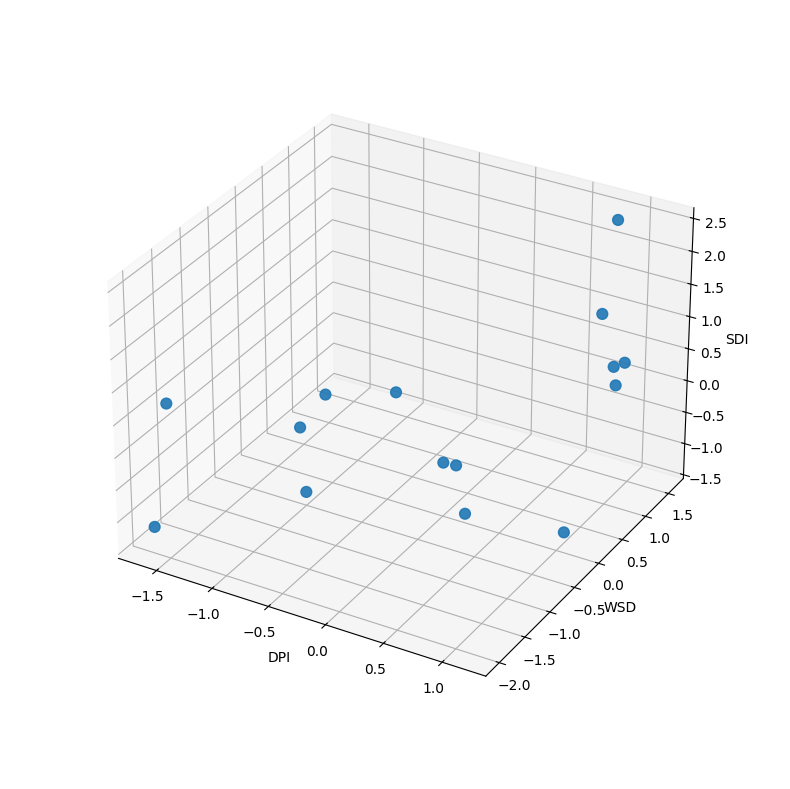

In [5]:
from analysis.characterisation.plotting.plot_features import plot_feature_space

plot_feature_space(X)